In [4]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

import rasterio
import rasterio.merge
import rasterio.mask
import geopandas as gpd
from osgeo import gdal, osr, ogr
from shapely.geometry import box
import fiona

## Functions

In [5]:
def get_tif_corners(tif_path):
    '''https://nsidc.org/support/faq/how-can-i-reproject-geotiff-file-polar-stereographic-projecton-geographic-latlon'''
    ds=gdal.Open(tif_path)

    gt=ds.GetGeoTransform()
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    ext=GetExtent(gt,cols,rows)

    src_srs=osr.SpatialReference()
    src_srs.ImportFromWkt(ds.GetProjection())
    #tgt_srs=osr.SpatialReference()
    #tgt_srs.ImportFromEPSG(4326)
    tgt_srs = src_srs.CloneGeogCS()
    geo_ext = np.array(ReprojectCoords(ext, src_srs, tgt_srs))
    return geo_ext


def load_tif_as_array(tiff_file):
    '''https://gis.stackexchange.com/questions/154669/editing-tiff-rasters-in-python/285685#285685'''
    geotransform = tiff_file.GetGeoTransform()
    projection = tiff_file.GetProjection()
    band = tiff_file.GetRasterBand(1)    
    xsize = band.XSize
    ysize = band.YSize
    array = band.ReadAsArray()
    tiff_file = None #close it
    band = None #close it
    return array


def GetExtent(gt,cols,rows):
    ''' Return list of corner coordinates from a geotransform

        @type gt:   C{tuple/list}
        @param gt: geotransform
        @type cols:   C{int}
        @param cols: number of columns in the dataset
        @type rows:   C{int}
        @param rows: number of rows in the dataset
        @rtype:    C{[float,...,float]}
        @return:   coordinates of each corner
    '''
    ext=[]
    xarr=[0,cols]
    yarr=[0,rows]

    for px in xarr:
        for py in yarr:
            x=gt[0]+(px*gt[1])+(py*gt[2])
            y=gt[3]+(px*gt[4])+(py*gt[5])
            ext.append([x,y])
            print(x,y)
        yarr.reverse()
    return ext

def ReprojectCoords(coords,src_srs,tgt_srs):
    ''' Reproject a list of x,y coordinates.

        @type geom:     C{tuple/list}
        @param geom:    List of [[x,y],...[x,y]] coordinates
        @type src_srs:  C{osr.SpatialReference}
        @param src_srs: OSR SpatialReference object
        @type tgt_srs:  C{osr.SpatialReference}
        @param tgt_srs: OSR SpatialReference object
        @rtype:         C{tuple/list}
        @return:        List of transformed [[x,y],...[x,y]] coordinates
    '''
    trans_coords=[]
    transform = osr.CoordinateTransformation( src_srs, tgt_srs)
    for x,y in coords:
        x,y,z = transform.TransformPoint(x,y)
        trans_coords.append([x,y])
    return trans_coords

def get_tif_corners(path):
    ds=gdal.Open(path)

    gt=ds.GetGeoTransform()
    cols = ds.RasterXSize
    rows = ds.RasterYSize
    ext = np.array(GetExtent(gt,cols,rows))
# 
    # src_srs=osr.SpatialReference()
    # src_srs.ImportFromWkt(ds.GetProjection())
# 
    # tgt_srs = src_srs.CloneGeogCS()
# 
    # geo_ext=np.array(ReprojectCoords(ext, src_srs, tgt_srs))

    # X = lon/easting, Y = lat/northing
    x_min, x_max = np.min(ext[:, 0]), np.max(ext[:, 0])
    y_min, y_max = np.min(ext[:, 1]), np.max(ext[:, 1])
    
    return x_min, x_max, y_min, y_max

def merge_tifs(tif_path, write_path, **kwargs):
    '''Merges two tif files together using rasterio merge'''
    dataset1 = rasterio.open(tif_path[0])
    dataset2 = rasterio.open(tif_path[1])

    dest, output_transform = rasterio.merge.merge([dataset1,dataset2], **kwargs)

    with rasterio.open(ocean_mask_path) as src:
            out_meta = src.meta.copy()    
            out_meta.update({"driver": "GTiff",
                             "height": dest.shape[1],
                             "width": dest.shape[2],
                             "transform": output_transform})

    with rasterio.open(write_path, "w", **out_meta) as dest1:
            dest1.write(dest)
            
def get_bounds(bounds, padding=[0.01, 0.005, 0.01, 0.005]):
    '''Takes rasterio tif bounds as input. 
    Padding is a list of padding given in percentage of 
    bound size, and follows same order as bounds'''
    
    left_bound = bounds.left  - np.abs(bounds.left * padding[0])
    right_bound = bounds.right  + np.abs(bounds.right * padding[2])
    top_bound = bounds.top  + np.abs(bounds.top * padding[3])
    bottom_bound = bounds.bottom  - np.abs(bounds.bottom * padding[1])
    
    return left_bound, bottom_bound, right_bound, top_bound

def make_coordinate_arrays(raster_path):
    ds = gdal.Open(raster_path, gdal.GA_ReadOnly)
    gt = ds.GetGeoTransform()
    
    data = rasterio.open(raster_path)
    
    # build vector of coordinates from geotransform and array
    col = np.arange(0, data.read(1).shape[1])
    row = np.arange(0, data.read(1).shape[0])

    # col, row to x, y
    x = np.add(np.multiply(col, gt[1]), gt[0])
    y = np.add(np.multiply(row, gt[5]), gt[3])
    
    return x, y

def unit_test_bounds(raster_bounded, raster_bounds):
    '''Compare the raster which should be bounded by raster bounds by plotting the raster and the wanted bounds on top'''
    left_bound, bottom_bound, right_bound, top_bound = raster_bounds[:]
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 9)
    plt.imshow(ocean_mask.read(1), 
               extent=[ocean_mask.bounds.left, 
                       ocean_mask.bounds.right, 
                       ocean_mask.bounds.bottom, 
                       ocean_mask.bounds.top], zorder=1)
    ax.scatter([left_bound, left_bound, right_bound, right_bound], [top_bound, bottom_bound, top_bound, bottom_bound], color='red', zorder=2, s=100)
    plt.show()
    
def crop_raster_to_bounds(raster_path, bounds):
    '''crop raster to bounds (l, b, r, t) tuple. Saves cropped raster in new file'''
    shape = gpd.GeoDataFrame({"id":1,"geometry":[box(*bounds)]})
    shape.to_file("tmp.shp")

    with fiona.open("tmp.shp", "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    new_name = raster_path.split(".")[0] + "_cropped.tif"

    with rasterio.open(new_name, "w", **out_meta) as dest:
        dest.write(out_image)
        
    os.remove("tmp.shp")
    os.remove("tmp.cpg")
    os.remove("tmp.dbf")
    os.remove("tmp.shx")
    return new_name

In [37]:
os.remove("mergedRasters.tif")

## Paths

In [6]:
promice_mask_path = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/PROMICE_icemask_100_AndersKusk/PROMICE_icemask_100.tif'
coherence_path_1 = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/coherence/Coher_20170715_20170721_5_1_1_1_ortho.tif'
coherence_path_2 = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/coherence/Coher_20170709_20170715_5_1_1_1_ortho.tif'
ocean_mask_path = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/gimp/GimpOceanMask_15m_tile1_3_v1.1.tif'
ocean_mask_path_1 = '/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/gimp/GimpOceanMask_15m_tile1_2_v1.1.tif'
coherence_stereo_path = "/Users/eyu/Google Drive/DTU/11_semester/master_thesis/preliminary_coding/first_simulations/coherence_stere.tif"
merged_ocean_mask_path = os.getcwd() + "/merged_ocean_mask.tif"

In [7]:
ocean_mask = rasterio.open(ocean_mask_path)
ice_mask = rasterio.open(promice_mask_path)
coherence_stereo = rasterio.open(coherence_stereo_path)

#### Get coherence bounding box

In [8]:
left_bound, bottom_bound, right_bound, top_bound = get_bounds(coherence_stereo.bounds, padding=[0.01, 0.005, 0.01, 0.005])

#### Crop ice mask to bounding box

In [9]:
new_ice_mask_path = crop_raster_to_bounds(promice_mask_path, (left_bound, bottom_bound, right_bound, top_bound))

In [10]:
ice_mask_cropped = rasterio.open(new_ice_mask_path)

#### Load ocean mask

In [11]:
coherence_bounds = (left_bound, bottom_bound, right_bound, top_bound)# coherence_stereo.bounds
merge_tifs([ocean_mask_path, ocean_mask_path_1], merged_ocean_mask_path, bounds=coherence_bounds)

In [12]:
ocean_mask = rasterio.open(merged_ocean_mask_path)

#### Make coordinate grid

In [13]:
x_coherence, y_coherence = make_coordinate_arrays(coherence_stereo_path)
y_coherence = np.flip(y_coherence)
x_coh_grid, y_coh_grid = np.meshgrid(x_coherence, y_coherence)

####  Ocean mask coordinates

In [14]:
x_ocean, y_ocean = make_coordinate_arrays(merged_ocean_mask_path)

####  Ice mask coordinates

In [15]:
x_ice, y_ice = make_coordinate_arrays(new_ice_mask_path)

#### Interpolate

In [19]:
RGI_ocean = RegularGridInterpolator((np.flip(y_ocean), x_ocean), np.flipud(ocean_mask.read(1)), method='nearest')

In [21]:
RGI_ice = RegularGridInterpolator((np.flip(y_ice), x_ice), np.flipud(ice_mask_cropped.read(1)), method='nearest')

In [22]:
coordinates = np.vstack((y_coh_grid.flatten(), x_coh_grid.flatten())).T

In [23]:
ocean_mask_interpolated = RGI_ocean(coordinates).reshape(y_coh_grid.shape)

In [24]:
ice_mask_interpolated = RGI_ice(coordinates).reshape(y_coh_grid.shape)

In [25]:
combined_masks = ocean_mask_interpolated + ice_mask_interpolated

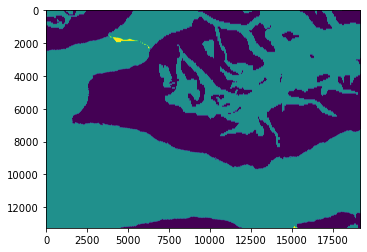

In [26]:
plt.imshow(np.flipud(combined_masks))

In [29]:
ocean_mask_interpolated_uint8 = (ocean_mask_interpolated * 255.999) .astype(np.uint8)  # right, Janna, not 256
ice_mask_interpolated_uint8 = (ice_mask_interpolated * 255.999) .astype(np.uint8)  # right, Janna, not 256

In [30]:
np.save("/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/ocean_mask_karrat.npy", ocean_mask_interpolated_uint8)
np.save("/Users/eyu/Google Drive/DTU/11_semester/master_thesis/data/ice_mask_karrat.npy", ice_mask_interpolated_uint8)